In [1]:
# Standard libraries
from joblib import Parallel, delayed
import glob
import sys
sys.path.append('../../')


# Third party libraries
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import SimpleITK as sitk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import scipy.ndimage
from sklearn.neighbors import KernelDensity

# Our libraries
from gui.gui_shared import auto_contrast

In [2]:
def readTifWrapper(i, file_name):
    """
    i - index for parallel processing
    file_name - file name to open
    """
    image = readTifSection(str(file_name))
    return [i, image]


def readTifSection(file_path):
    """
    Read tif section image using SITK
    """
    image = sitk.ReadImage(str(file_path))
    image = sitk.GetArrayFromImage(image)
    image[image < 0] = 0
    image = image.T
    image = np.flip(image, axis=0)
    image = np.flip(image, axis=1)
    image  = np.squeeze(image)
    return image


def intensity_histogram(image: np.ndarray, bins=10, 
                        max_freq=None, min_intensity=None, max_intensity=None,
                        title='Histogram of intensity values'):
    """
    Plot a histogram of the intensity values in the image
    """
    # Flatten the 3D array into a 1D array
    flattened_image = image.flatten()
    
    # If min_intensity is specified, filter the flattened image
    if min_intensity is not None:
        flattened_image = flattened_image[flattened_image >= min_intensity]
    
    # If max_intensity is specified, filter the flattened image
    if max_intensity is not None:
        flattened_image = flattened_image[flattened_image <= max_intensity]
    
    hist, bin_edges = np.histogram(flattened_image, bins=bins, 
                                   range=(0, max_intensity if max_intensity is not None else np.max(flattened_image)))
    
    # Filter the bins to include only those with frequencies below max_freq if max_freq is not None
    if max_freq is not None:
        mask = hist < max_freq
        filtered_hist = hist[mask]
        filtered_bin_edges = bin_edges[:-1][mask]
        filtered_bin_widths = np.diff(bin_edges)[mask]
    else:
        filtered_hist = hist
        filtered_bin_edges = bin_edges[:-1]
        filtered_bin_widths = np.diff(bin_edges)
    
    # Compute and plot the histogram
    plt.figure(figsize=(6, 4))  # 12, 8
    plt.bar(filtered_bin_edges, filtered_hist, width=filtered_bin_widths, color='skyblue', alpha=0.75, edgecolor='black', align='edge')
    plt.title(title, fontsize=16)
    plt.xlabel('Intensity value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
  
    # Format the y-axis to display large numbers with commas
    def format_func(value, tick_number):
        return f'{int(value):,}'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

    plt.tight_layout()
    plt.show()


def intensity_stats(image: np.ndarray):
    """
    Summary statistics of the intensity values in the image
    """
    print("Image shape:", image.shape)
    flattened_image = image.flatten()
    min_intensity = np.min(flattened_image)
    print(f'Minimum intensity: {min_intensity}')
    max_intensity = np.max(flattened_image)
    print(f'Maximum intensity: {max_intensity}')
    mean_intensity = np.mean(flattened_image)
    print(f'Mean intensity: {mean_intensity}')
    median_intensity = np.median(flattened_image)
    print(f'Median intensity: {median_intensity}')
    #std_intensity = np.std(flattened_image)  # This crashes the PC
    #print(f'Standard deviation: {std_intensity}')
    return min_intensity, max_intensity, mean_intensity, median_intensity



def compute_density_map(image: np.ndarray, bandwidth=1.0, downsample_factor=2):
    """
    Compute a density map of intensity values for an image using kernel density estimation.
    
    Parameters:
    - image: 2D numpy array representing the image.
    - bandwidth: Bandwidth for the kernel density estimation.
    - downsample_factor: Factor by which to downsample the image.
    
    Returns:
    - density_map: 2D numpy array representing the density map.
    """
    # Downsample the image
    downsampled_image = scipy.ndimage.zoom(image, 1.0 / downsample_factor)
    
    # Flatten the downsampled image to get the intensity values
    flattened_image = downsampled_image.flatten().reshape(-1, 1)
    
    # Use KernelDensity from sklearn to compute the density of the intensity values
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(flattened_image)
    
    # Evaluate the density on the intensity values
    density_values = kde.score_samples(flattened_image)
    density_values = np.exp(density_values)  # Convert log density to density
    
    # Reshape the density values back to the downsampled image shape
    density_map_downsampled = density_values.reshape(downsampled_image.shape)
    
    # Upsample the density map back to the original image size
    density_map = scipy.ndimage.zoom(density_map_downsampled, downsample_factor)
    
    return density_map


def count_cells(image):
    """
    Count the number of cells in the image
    """
    return


# Create a histogram of watershed sizes after peak intensity operation

### Load in tiff data

In [3]:
# Parameters for loading in the data
img_dir = "/media/data/u01/B0039/stitched_ch0/"
gt140_dir = "/media/data/u01/B0039/red_section140_counts_240930_PG/red_section140_counts_240930_PG.txt"
start = 100  # Starting index to load images
end = 150    # Ending index to load images

# Load in the images
tif_files = natsorted(glob.glob(img_dir + "/*.tif", recursive=True))[start:end]
brain = Parallel(n_jobs=-2, verbose=13)(delayed(readTifWrapper)(i, fn) for i, fn in enumerate(tif_files))
brain = sorted(brain)
brain = np.array([img for _, img in brain])
print("Brain shape:", brain.shape)

gt140 = np.loadtxt(gt140_dir, skiprows=2)
gt140 = gt140[:, 1:]  # Remove section index row
print("Ground truth (section 140) shape:", gt140.shape)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-2)]: Done  16 tasks      | elapsed:   14.3s
[Paralle

Brain shape: (50, 8716, 11236)
Ground truth (section 140) shape: (66, 2)


In [4]:
# Show all of the sections loaded in memory.
SHOW_ALL = False
num_sections = brain.shape[0]

if SHOW_ALL:
    for i in range(num_sections):
        curr_section = brain[i, :, :].copy()
        curr_section = auto_contrast(curr_section, alpha=0.1)
        plt.imshow(curr_section, cmap='gray')
        plt.title(f"Section {i + start}")
        plt.show()

### Show statistics for full brain volume

Image shape: (50, 8716, 11236)
Minimum intensity: 0
Maximum intensity: 46882
Mean intensity: 62.60817539722269
Median intensity: 17.0


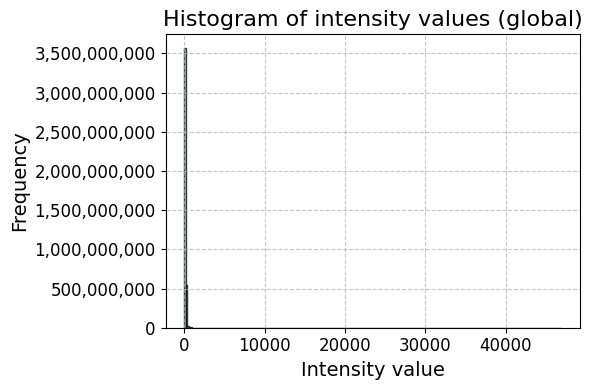

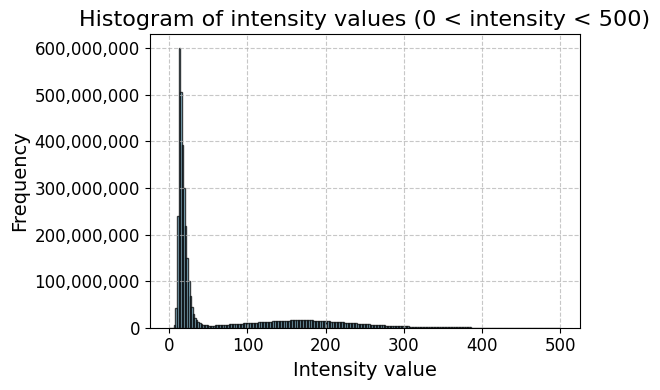

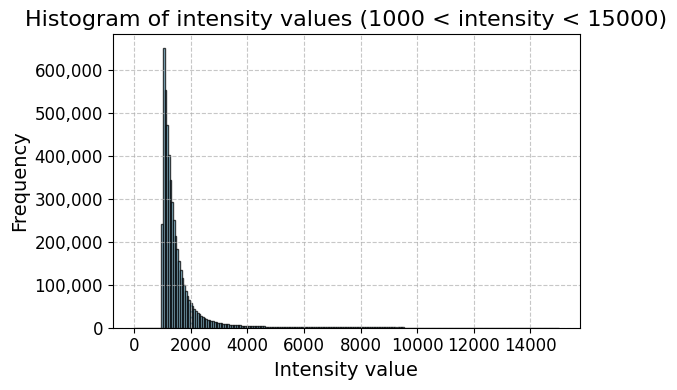

In [5]:
intensity_stats(brain)
intensity_histogram(brain, bins=250, min_intensity=1, 
                    title='Histogram of intensity values (global)')
intensity_histogram(brain, bins=250, min_intensity=1, max_intensity=500, 
                    title='Histogram of intensity values (0 < intensity < 500)')
intensity_histogram(brain, bins=250, min_intensity=1000, max_intensity=15000, 
                    title='Histogram of intensity values (1000 < intensity < 15000)')

### Process and show statistics for specific brain section

Image shape: (8716, 11236)
Minimum intensity: 0
Maximum intensity: 31877
Mean intensity: 66.66915517812917
Median intensity: 17.0


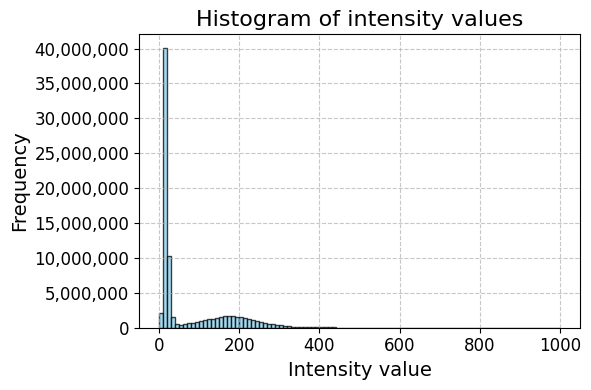

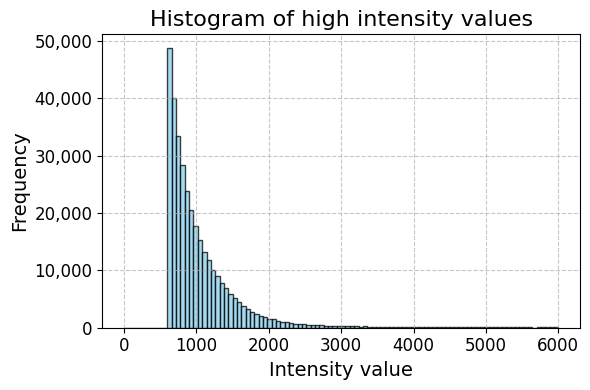

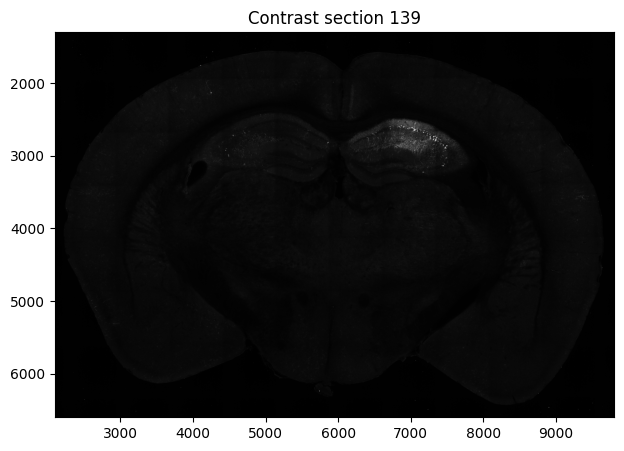

In [6]:
# Apply contrast to the brain images to make it easier to see the structures
CURR_IDX = 39
ALPHA = 0.05

# Create two separate copies of the current section
curr_section = brain[CURR_IDX, :, :].copy()
curr_contrast = auto_contrast(curr_section, alpha=ALPHA)

# Print the intensity statistics of the current section
intensity_stats(curr_section)

# Show intensity histogram of current section
intensity_histogram(curr_section, bins=100, min_intensity=1, max_intensity=1000)
intensity_histogram(curr_section, bins=100, min_intensity=600, max_intensity=6000, title='Histogram of high intensity values')


# Show the full contrasted section
y_section_boundary = (1300, 6600)
x_section_boundary = (2100, 9800)  # Crop out most of the background
plt.figure(figsize=(10, 5))  # 20, 10
plt.imshow(curr_contrast, cmap='gray')
plt.xlim(x_section_boundary)
plt.ylim(y_section_boundary[::-1])
plt.title(f"Contrast section {CURR_IDX + start}")
plt.show()


### Region of interest analysis (dorsal hippocampus dCA1)

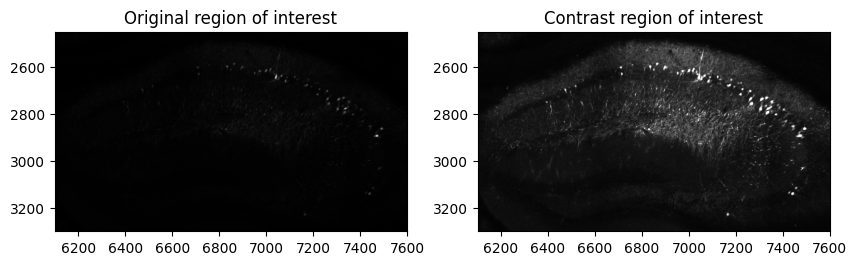

Image shape: (850, 1500)
Minimum intensity: 17
Maximum intensity: 31877
Mean intensity: 484.0943576470588
Median intensity: 335.0


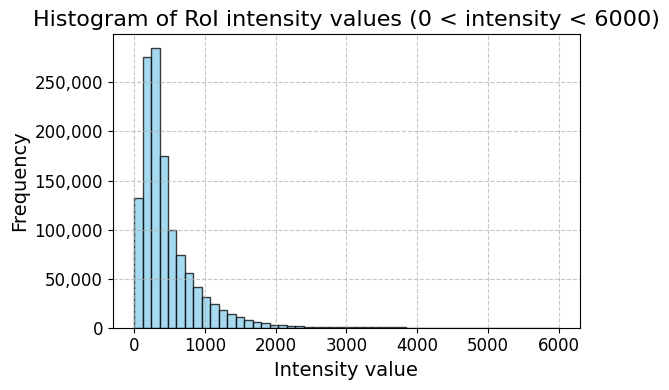

In [7]:
# Show the region of interest
y_roi_boundary = (2450, 3300)
x_roi_boundary = (6100, 7600)  # Crop the section to the region of interest
curr_roi = curr_section[y_roi_boundary[0]:y_roi_boundary[1], x_roi_boundary[0]:x_roi_boundary[1]]
curr_roi_contrast = curr_contrast[y_roi_boundary[0]:y_roi_boundary[1], x_roi_boundary[0]:x_roi_boundary[1]]

# Show visual comparison of the original and contrasted region of interest
plt.figure(figsize=(10, 5))  # 20, 10
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(curr_section, cmap='gray')
plt.xlim(x_roi_boundary)
plt.ylim(y_roi_boundary[::-1])
plt.title("Original region of interest")
plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(curr_contrast, cmap='gray')
plt.xlim(x_roi_boundary)
plt.ylim(y_roi_boundary[::-1])
plt.title("Contrast region of interest")
plt.show()

# Show and compute density map
#density_map = compute_density_map(curr_roi_contrast, bandwidth=0.1)
#plt.imshow(density_map, cmap='hot')
#plt.colorbar()
#plt.title('Density map of the region of interest')
#plt.show()

# Print the intensity statistics of the region of interest
intensity_stats(curr_roi)
intensity_histogram(curr_roi, bins=50, min_intensity=1, max_intensity=6000, title='Histogram of RoI intensity values (0 < intensity < 6000)')

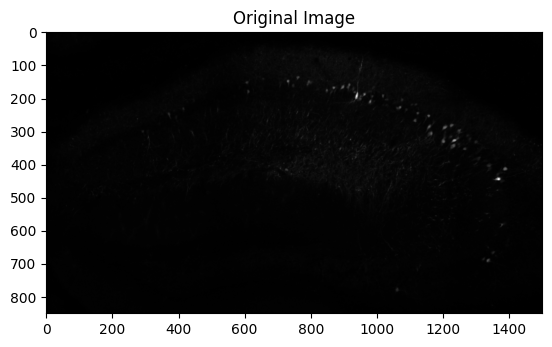

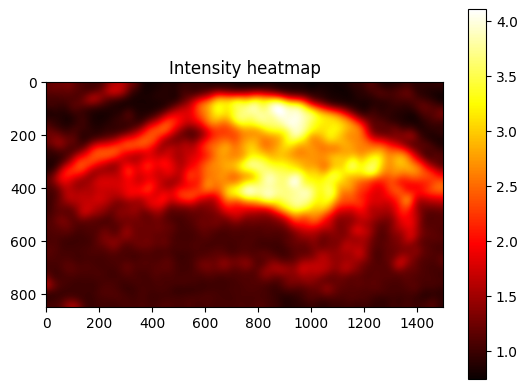

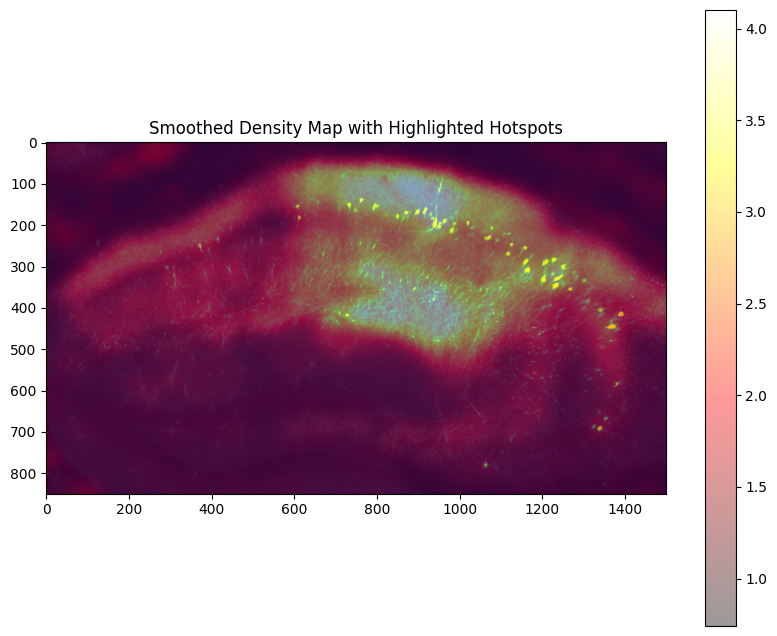

In [8]:
def compute_density_map(image: np.ndarray, bandwidth=1.0, downsample_factor=2, power=2):
    """
    Compute a density map of intensity values for an image using kernel density estimation.
    
    Parameters:
    - image: 2D numpy array representing the image.
    - bandwidth: Bandwidth for the kernel density estimation.
    - downsample_factor: Factor by which to downsample the image.
    
    Returns:
    - density_map: 2D numpy array representing the density map.
    """
    # Downsample the image
    downsampled_image = scipy.ndimage.zoom(image, 1.0 / downsample_factor)
        
    # Flatten the downsampled image to get the intensity values
    flattened_image = downsampled_image.flatten().reshape(-1, 1)
    
    # Use KernelDensity from sklearn to compute the density of the intensity values
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(flattened_image)
    
    # Evaluate the density on the intensity values
    density_values = kde.score_samples(flattened_image)
    #density_values = np.exp(density_values)  # Convert log density to density
    
    # Apply the power transformation to emphasize larger values
    #density_values = density_values ** power
    
    # Apply a logarithmic transformation to compress smaller values
    #density_values = np.log1p(density_values) ** 4
    
    # Reshape the density values back to the downsampled image shape
    density_map_downsampled = density_values.reshape(downsampled_image.shape)
    
    # Upsample the density map back to the original image size
    density_map = scipy.ndimage.zoom(density_map_downsampled, downsample_factor)
    density_map = np.max(density_map) - density_map
    return density_map

# Example usage
# image = np.random.randint(0, 256, (100, 100))  # Example image
density_roi = curr_roi.copy()
#density_roi = (density_roi/np.iinfo(density_roi.dtype).max)*255
#density_roi = density_roi.astype(np.uint8)

plt.imshow(density_roi, cmap='gray')
plt.title('Original Image')
plt.show()

density_map = compute_density_map(density_roi, bandwidth=1, downsample_factor=10)
#plt.imshow(density_map, cmap='gray')
#plt.show()

# Apply a Gaussian filter to smooth the density map
smoothed_density_map = scipy.ndimage.gaussian_filter(density_map, sigma=20)

plt.imshow(smoothed_density_map, cmap='hot')
plt.colorbar()
plt.title('Intensity heatmap')
plt.show()

# Apply a threshold to highlight high-intensity areas
#threshold = np.percentile(smoothed_density_map, 85)  # Adjust the percentile as needed
#highlighted_density_map = np.ma.masked_less(smoothed_density_map, threshold)
#highlighted_density_map = scipy.ndimage.gaussian_filter(highlighted_density_map, sigma=5)
#plt.imshow(highlighted_density_map, cmap='hot')
#plt.colorbar()
#plt.title('Density heatmap with highlighted hotspots')
#plt.show()
#highlighted_density_map = scipy.ndimage.gaussian_filter(highlighted_density_map, sigma=1)

# Apply a higher threshold to highlight the top intensity values
#higher_threshold = np.percentile(smoothed_density_map, 95)  # Adjust the percentile as needed
#highlighted_high_density_map = np.ma.masked_less(smoothed_density_map, higher_threshold)

# Plot the smoothed density map with highlighted hotspots
plt.figure(figsize=(10, 8))
plt.imshow(curr_roi_contrast, cmap='viridis', alpha=1)  # Overlay the original image
plt.imshow(smoothed_density_map, cmap='hot', alpha=0.4)
plt.colorbar()
#plt.imshow(highlighted_density_map, cmap='cool', alpha=0.3)  # Use a different colormap for hotspots
#plt.imshow(highlighted_high_density_map, cmap='hot', alpha=0.3)  # Use another colormap for even higher hotspots
plt.title('Smoothed Density Map with Highlighted Hotspots')
plt.show()

Dice Coefficient: 0.504424778761062


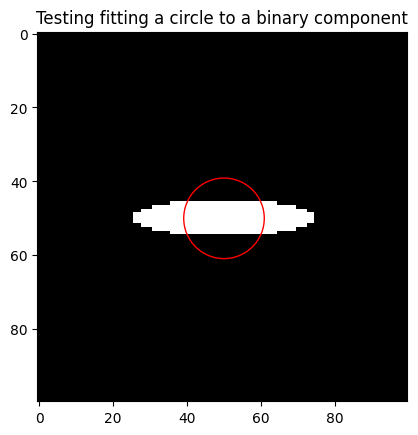

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage.measure import regionprops, label
from skimage.draw import disk
from matplotlib.patches import Circle
from skimage.draw import ellipse
from matplotlib.patches import Ellipse


def compute_dice_coefficient(binary_image1, binary_image2):
    """
    Compute the Dice coefficient between two binary images.
    
    Parameters:
    - binary_image1: 2D numpy array representing the first binary image.
    - binary_image2: 2D numpy array representing the second binary image.
    
    Returns:
    - dice_coefficient: The Dice coefficient between the two binary images.
    """
    intersection = np.logical_and(binary_image1, binary_image2)
    return 2. * intersection.sum() / (binary_image1.sum() + binary_image2.sum())


def compute_circle_conformity(binary_image):
    """
    Compute how much a connected component in a binary image conforms to a circular shape.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - dice_coefficient: A measure of how much the connected component conforms to a circular shape.
    """
    # Label the connected components
    labeled_image, num_features = scipy.ndimage.label(binary_image)
    
    # Extract properties of the labeled connected component
    props = regionprops(labeled_image)
    
    if len(props) == 0:
        raise ValueError("No connected component found in the binary image.")
    
    # Assuming we are interested in the largest connected component
    largest_component = max(props, key=lambda x: x.area)
    
    # Get the properties of the largest connected component
    y0, x0 = largest_component.centroid
    equivalent_diameter = largest_component.equivalent_diameter
    
    # Create a binary image of the fitted circle
    fitted_circle = np.zeros_like(binary_image)
    rr, cc = disk((int(y0), int(x0)), int(equivalent_diameter / 2))
    fitted_circle[rr, cc] = 1
    
    # Compute the area of the fitted circle
    #circle_area = np.pi * (equivalent_diameter / 2) ** 2
    
    # Compute the area of the connected component
    #component_area = largest_component.area
    
    # Compute the conformity as the ratio of the component area to the circle area
    #conformity = component_area / circle_area
    
    # Compute the Dice coefficient
    dice_coefficient = compute_dice_coefficient(binary_image, fitted_circle)
    
    return dice_coefficient, (y0, x0, equivalent_diameter)

# Example usage
binary_image = np.zeros((100, 100), dtype=np.uint8)
rr, cc = ellipse(50, 50, 5, 25)
binary_image[rr, cc] = 1

dice_coefficient, circle_params = compute_circle_conformity(binary_image)
print(f"Dice Coefficient: {dice_coefficient}")

# Plot the binary image and the fitted circle
y0, x0, equivalent_diameter = circle_params
fig, ax = plt.subplots()
ax.imshow(binary_image, cmap='gray')

# Draw the fitted circle
circle_patch = Circle((x0, y0), equivalent_diameter / 2, edgecolor='red', facecolor='none')
ax.add_patch(circle_patch)

plt.title('Testing fitting a circle to a binary component')
plt.show()

### Run cell counting

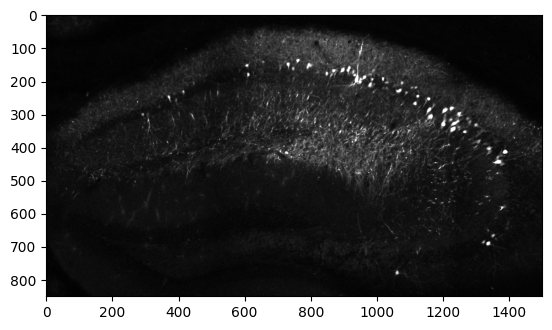

Peaks shape: (326, 2)
Peaks: [[ 195  939]
 [ 446 1369]
 [ 329 1234]
 [ 191  963]
 [ 213  980]
 [ 151  731]
 [ 169  897]
 [ 327  920]
 [ 291 1206]
 [ 171  870]
 [ 415 1388]
 [ 288 1158]
 [ 332 1202]
 [ 229 1070]
 [ 255 1158]
 [ 308 1165]
 [ 692 1336]
 [ 343 1232]
 [ 162  917]
 [ 284 1227]
 [ 178  849]
 [ 270 1115]
 [ 355  890]
 [ 584 1379]
 [ 138  764]
 [ 244  760]
 [ 299 1250]
 [ 247 1123]
 [ 153  795]
 [ 381  936]
 [ 356  814]
 [ 418  727]
 [ 195 1019]
 [ 204  952]
 [ 102  954]
 [ 414  709]
 [ 355 1266]
 [ 254  792]
 [ 326  813]
 [ 430  741]
 [ 155  943]
 [ 410 1103]
 [ 480  946]
 [ 469  886]
 [ 432 1062]
 [ 196  951]
 [ 322  771]
 [ 184  611]
 [ 477  976]
 [ 355 1064]
 [ 111  952]
 [ 155  606]
 [ 335  855]
 [ 271  668]
 [ 371  938]
 [ 118  949]
 [ 197  987]
 [ 468  983]
 [ 385  926]
 [ 463 1191]
 [ 405  674]
 [ 264  277]
 [ 479 1365]
 [ 344  954]
 [ 406 1341]
 [ 320  309]
 [ 248  371]
 [ 338  829]
 [ 319 1224]
 [ 347  962]
 [ 207 1077]
 [ 315  813]
 [ 433 1089]
 [ 331 1415]
 [ 413 10

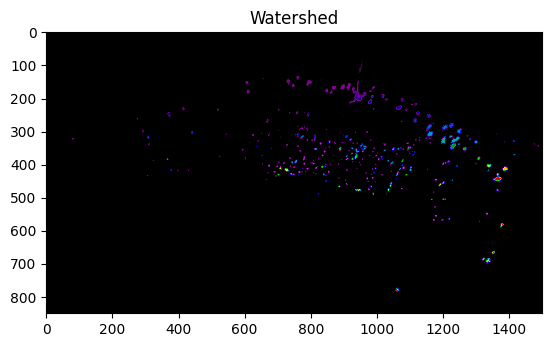

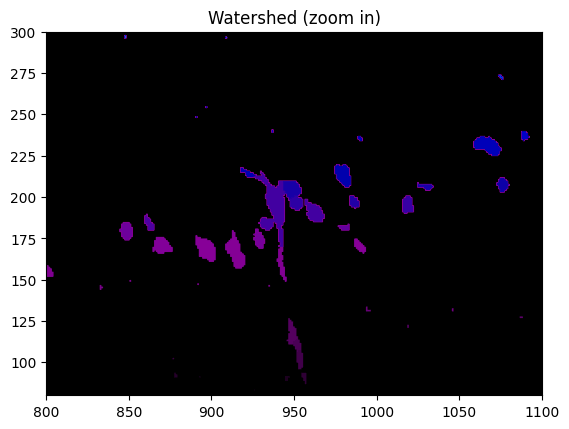

Sizes shape: (326,)
Sizes: [  2.   1.  11.   1.   7.   5.  15.   5.   1.  40.  27.  62.   2.   2.
   5.   2.  83.   9.   4.   1.   1.   2.   1.  97. 163.  56.  56.   1.
   2. 145.  47. 128.  36.  86.  55.  68.  10.   9.  57.  36. 105. 358.
  62.  58.  37.  94.  28.  48.   1. 103.  27.  27.  10. 130.  26.   7.
  10.   7.  21.   2.  23.   5.   2.  58.  57.   1.   1.  31.   1.  74.
   7.   1.  88.  26.   5.   5. 111.   2. 142.   3. 164.   8.   1.   1.
  13.  18.   2. 139.   1.  16.   3.   7.   1.  17.   2. 185.   1.   2.
   9.   3.   9.  28.   1.  17.   9.  17.   1.  41.  17.   2.  34.  10.
   5.   5.  12.  23.  20.   7.   5.   6.   1.   6.   3. 205.  10.   5.
 184.  58.   1.  30.   3.   1.   3.   1.  12.   5.  19.   3.   9.   4.
  22.  11.   9.   7.   4. 184.  27.   3.   4.   8.  32.   6.  49.   1.
   4.   1.  12.   9.  46.   6.  13.  17.   3.  66.  22.   6.  35.  19.
  14.   3.   8.  13.  32.   8.   1.   4.   5.   1.   2.  10.   5.  13.
   6.   8.  10.   1.   2.   2.   9.   4.  10.   7.

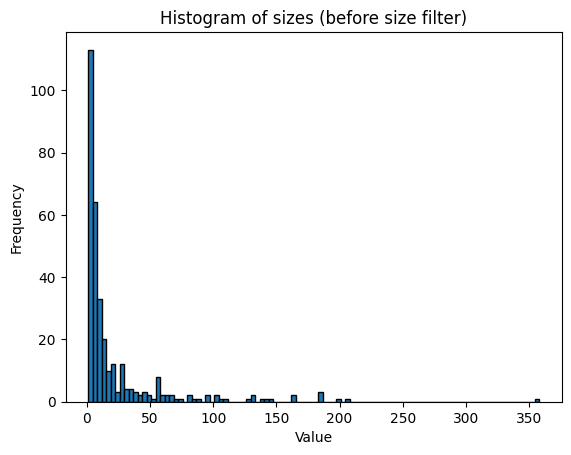

cells: [[  82  717]
 [  90  956]
 [ 101  953]
 [ 110  952]
 [ 117  948]
 [ 139  761]
 [ 151  731]
 [ 155  794]
 [ 154  607]
 [ 159  942]
 [ 165  915]
 [ 163  747]
 [ 168  896]
 [ 169  989]
 [ 170  870]
 [ 174  928]
 [ 178  848]
 [ 181  982]
 [ 181  611]
 [ 183  862]
 [ 190  962]
 [ 194  938]
 [ 194 1018]
 [ 196  951]
 [ 196  986]
 [ 204  948]
 [ 206 1029]
 [ 207 1076]
 [ 212  979]
 [ 214  921]
 [ 220 1118]
 [ 221 1106]
 [ 230 1067]
 [ 233  415]
 [ 236  519]
 [ 236 1089]
 [ 244  759]
 [ 247 1123]
 [ 250  371]
 [ 251  792]
 [ 255 1156]
 [ 269 1115]
 [ 270  668]
 [ 283 1226]
 [ 288 1157]
 [ 290 1205]
 [ 295  768]
 [ 295  789]
 [ 301 1249]
 [ 302  292]
 [ 305  441]
 [ 309 1162]
 [ 312  761]
 [ 315  812]
 [ 317  908]
 [ 318 1224]
 [ 319  308]
 [ 319  773]
 [ 321 1150]
 [ 324 1281]
 [ 325  812]
 [ 326  920]
 [ 328 1235]
 [ 330 1415]
 [ 330 1201]
 [ 333 1299]
 [ 333  856]
 [ 337  873]
 [ 338  829]
 [ 341 1024]
 [ 340 1247]
 [ 346 1230]
 [ 344  953]
 [ 347  963]
 [ 352 1097]
 [ 352  925]
 [ 35

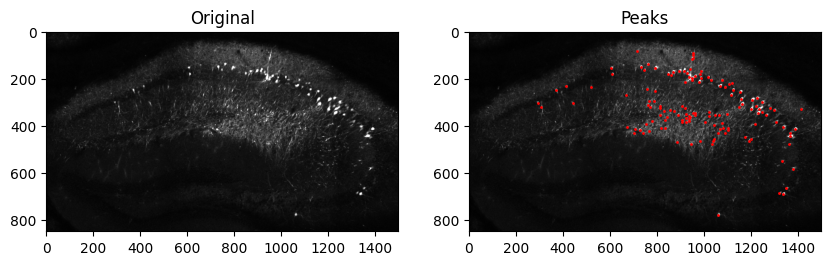

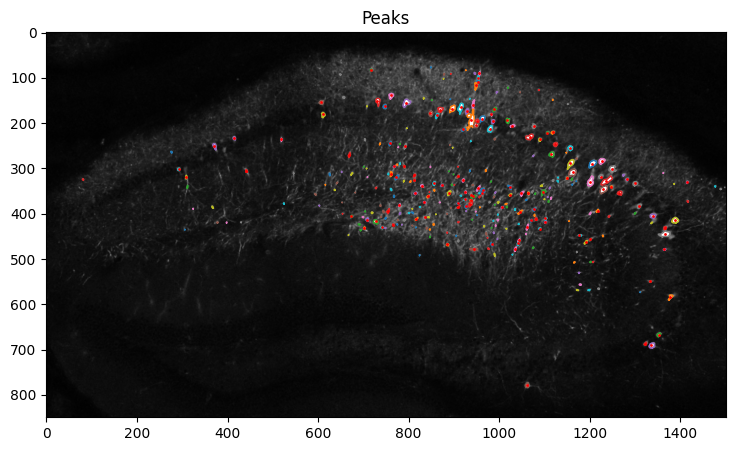

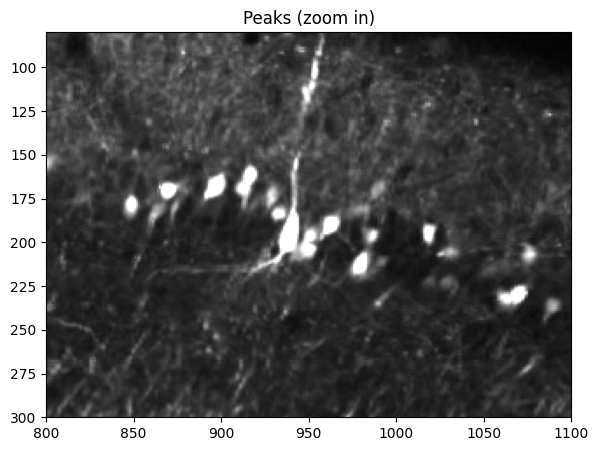

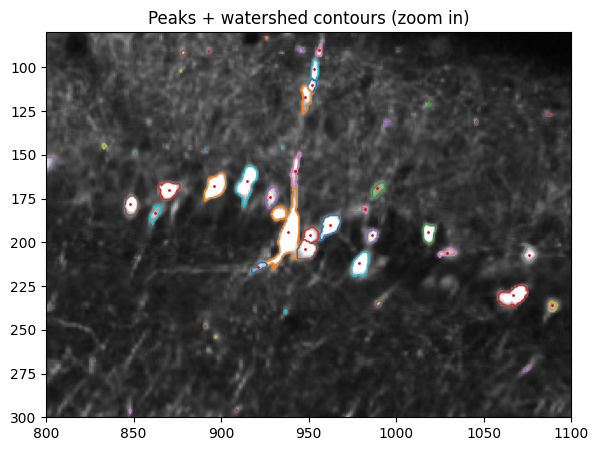

In [10]:
# Parameters
min_distance = 5  # 5
intensity_threshold = 10  # 10
size_threshold = 10  # 30

count_roi = curr_roi.copy()

plt.imshow(curr_roi_contrast, cmap='gray')
plt.show()

# Normalize
count_roi = (count_roi/np.iinfo(count_roi.dtype).max)*255
count_roi = count_roi.astype(np.uint8)




peaks = peak_local_max(count_roi, min_distance=min_distance, threshold_abs=intensity_threshold)
#peaks = peak_local_max(count_roi, min_distance=min_distance, threshold_rel=0.1)


print("Peaks shape:", peaks.shape)
print("Peaks:", peaks)

mask = np.zeros(count_roi.shape)
mask[tuple(peaks.T)] = True
markers, _ = scipy.ndimage.label(mask)
print("markers")
print(markers)

# Size detection
watershed_mask = count_roi > intensity_threshold
labels = watershed(-count_roi, markers, mask = watershed_mask)

plt.imshow(labels, cmap='nipy_spectral')
plt.title("Watershed")
plt.show()

plt.imshow(labels, cmap='nipy_spectral')
plt.xlim(800, 1100)
plt.ylim(80, 300)
plt.title("Watershed (zoom in)")
plt.show()

# Compute the center of mass of each cell
centers = np.array(scipy.ndimage.center_of_mass(count_roi, labels, index=np.arange(1, np.max(labels) + 1)))
centers = centers.astype(int)

#print("Centers shape:", centers.shape)
#print("Centers:", centers)

# Filter out small cells
sizes = scipy.ndimage.sum(np.ones(labels.shape, dtype=bool), labels=labels, index=np.arange(1, np.max(labels) + 1))
print("Sizes shape:", sizes.shape)
print("Sizes:", sizes)

# Plot the histogram
plt.hist(sizes, bins=100, edgecolor='black')

# Add titles and labels
plt.title('Histogram of sizes (before size filter)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

cells = centers[sizes >= size_threshold]
print("cells:", cells)

intensity_stats(count_roi)

# Show the region of interest with the detected peaks
plt.figure(figsize=(10, 5))  # 20, 10
plt.subplot(1, 2, 1)
plt.imshow(curr_roi_contrast, cmap='gray')
plt.title("Original")
plt.subplot(1, 2, 2)
for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.imshow(curr_roi_contrast, cmap='gray')
plt.title("Peaks")
plt.show()




# Function to remove small connected components
def remove_small_components(binary_image, min_size):
    # Label the connected components
    labeled_image, num_features = scipy.ndimage.label(binary_image)
    
    # Compute the size of each connected component
    component_sizes = scipy.ndimage.sum(binary_image, labeled_image, range(num_features + 1))
    
    # Create a mask to keep only the components larger than min_size
    size_mask = component_sizes >= min_size
    
    # Remove small components
    filtered_image = size_mask[labeled_image]
    
    return filtered_image


# WS label show
ws_labels = labels.copy()
#ws_labels[ws_labels != 0] = 1
#ws_labels = remove_small_components(ws_labels, size_threshold)

# Find contours for each unique label in the watershed output
from skimage.measure import find_contours
contours = []
for label in np.unique(ws_labels):
    if label == 0:
        continue  # Skip the background
    contours.extend(find_contours(ws_labels == label, 0.5))

"""
ws_mask = np.zeros(count_roi.shape)
print("centers")
print(centers)
ws_mask[tuple(centers.T)] = True
ws_markers, _ = scipy.ndimage.label(ws_mask)
ws_labels = watershed(-count_roi, ws_markers, mask = watershed_mask)
ws_labels[ws_labels != 0] = 1
plt.imshow(ws_labels, cmap='nipy_spectral')
plt.show()
"""




# Show the region of interest with the detected peaks
plt.figure(figsize=(10, 5))  # 20, 10
plt.imshow(curr_roi_contrast, cmap='gray')
#plt.contour(ws_labels, colors='green', linewidths=1)

# Plot each contour with a different color
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)


for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.title("Peaks")
plt.show()

# Just the zoomed in contrast by itself
plt.figure(figsize=(10, 5))  # 20, 10
plt.imshow(curr_roi_contrast, cmap='gray')
plt.title("Peaks (zoom in)")
plt.xlim(800, 1100)
plt.ylim(300, 80)

# Show the region of interest with the detected peaks (zoomed in)
plt.figure(figsize=(10, 5))  # 20, 10
plt.imshow(curr_roi_contrast, cmap='gray')
#plt.contour(ws_labels, colors='green', linewidths=1)

# Plot each contour with a different color
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)

for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.title("Peaks + watershed contours (zoom in)")
plt.xlim(800, 1100)
plt.ylim(300, 80)
plt.show()

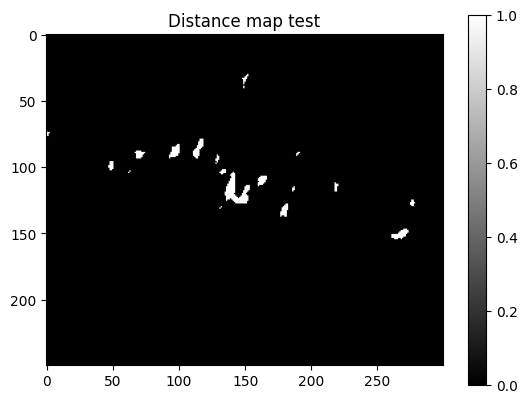

In [11]:
dmap = scipy.ndimage.distance_transform_edt(ws_labels)
dmap = dmap[80:330, 800:1100]
#thresh = np.percentile(dmap, 90)
#print("thresh:", thresh)
dmap = dmap > 2

plt.imshow(dmap, cmap='gray')
plt.colorbar()
plt.title('Distance map test')
plt.show()

In [12]:
### Ground truth analysis
print(gt140.shape)
print(gt140)

(66, 2)
[[2747.81341415 6393.47268444]
 [2695.88137939 6469.8433238 ]
 [2681.62552671 6513.62915703]
 [2601.18178659 6706.0831682 ]
 [2630.71176714 6711.17454416]
 [2590.99903467 6756.99692777]
 [2596.09041063 6831.33101674]
 [2611.3645385  6849.65997019]
 [2586.92593391 6859.8427221 ]
 [2861.86023558 7487.10024   ]
 [2626.63866637 6949.45093894]
 [2616.45591446 6969.81644277]
 [2618.49246484 7012.58400081]
 [2615.43763927 6995.27332256]
 [2619.28170464 7027.41990821]
 [2631.55880636 7032.19433666]
 [2645.8820917  7038.33288752]
 [2654.74888738 7048.56380562]
 [2645.20003049 7049.92792803]
 [2637.69735722 7062.88709096]
 [2645.20003049 7084.71304957]
 [2660.88743824 7079.25655992]
 [2617.91758222 7088.1233556 ]
 [2642.47178566 7117.45198749]
 [2680.66721323 7161.10390471]
 [2678.62102961 7169.9707004 ]
 [2654.74888738 7175.42719005]
 [2684.75958047 7189.06841418]
 [2669.75423393 7205.43788314]
 [2668.39011151 7217.03292365]
 [2694.99049857 7223.85353572]
 [2717.49851839 7214.98674003]


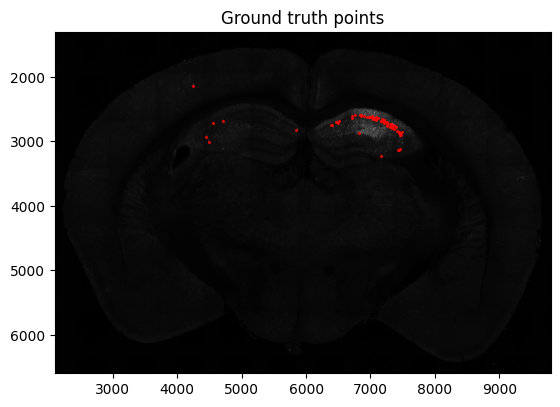

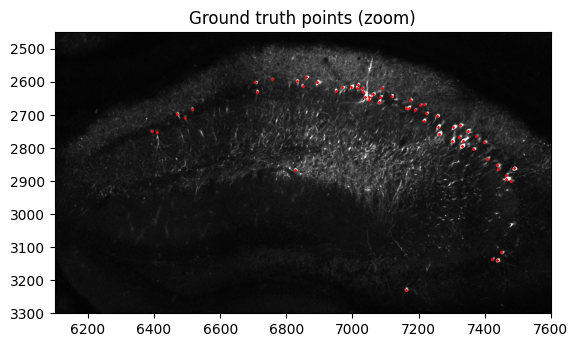

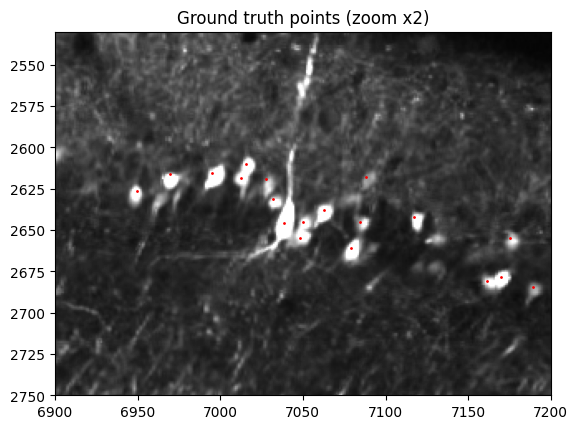

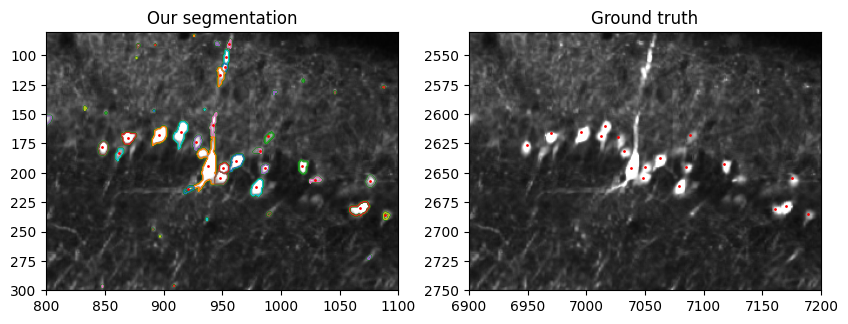

In [13]:
# Show the ground truth points on the contrasted section
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth points")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.xlim(x_section_boundary)
plt.ylim(y_section_boundary[::-1])
plt.show()

# Zoom in
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth points (zoom)")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.xlim(x_roi_boundary)
plt.ylim(y_roi_boundary[::-1])
plt.show()

# Zoom in further
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth points (zoom x2)")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
#plt.xlim(800, 1100)
#plt.ylim(80, 300)
plt.xlim(x_roi_boundary[0] + 800, x_roi_boundary[0] + 1100)
plt.ylim(y_roi_boundary[0] + 300, y_roi_boundary[0] + 80)
plt.show()


# Show our segmentation and ground truth
plt.figure(figsize=(10, 5))  # 20, 10

plt.subplot(1, 2, 1)
# Show the region of interest with the detected peaks (zoomed in)
plt.imshow(curr_roi_contrast, cmap='gray')
plt.contour(ws_labels, colors='green', linewidths=1)

# Plot each contour with a different color
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)

for p in cells:
    plt.plot(p[1], p[0], 'ro', markersize=1)
plt.title("Our segmentation")
plt.xlim(800, 1100)
plt.ylim(300, 80)

plt.subplot(1, 2, 2)
plt.imshow(curr_contrast, cmap='gray')
plt.title("Ground truth")
for p in gt140:
    plt.plot(p[1], p[0], 'ro', markersize=1)
#plt.xlim(800, 1100)
#plt.ylim(80, 300)
plt.xlim(x_roi_boundary[0] + 800, x_roi_boundary[0] + 1100)
plt.ylim(y_roi_boundary[0] + 300, y_roi_boundary[0] + 80)
plt.show()

### Experiment with Delaunay triangulation

https://scikit-image.org/docs/stable/auto_examples/applications/plot_human_mitosis.html

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.spatial import Delaunay, ConvexHull
from skimage.draw import disk
from sklearn.cluster import DBSCAN

# Function to get the points on the convex hull of a binary image
def convex_hull_points(binary_image):
    """
    Get the points on the convex hull of a binary image.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - hull_points: Coordinates of the points on the convex hull.
    """
    # Extract the coordinates of the foreground pixels
    points = np.column_stack(np.nonzero(binary_image))
    
    # Compute the convex hull
    hull = ConvexHull(points)
    
    # Get the coordinates of the points on the convex hull
    hull_points = points[hull.vertices]
    
    return hull_points


# Function to perform Delaunay triangulation on a binary image
def delaunay_triangulation(binary_image):
    """
    Perform Delaunay triangulation on a binary image.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - tri: Delaunay triangulation object.
    """
    # Extract the coordinates of the foreground pixels
    #hull_points = convex_hull_points(binary_image)
    points = get_boundary_points(binary_image)
    
    #points = hull_points[::2]
    #points = np.column_stack(np.nonzero(binary_image))
    #points = points[::200]
    
    # Perform Delaunay triangulation
    tri = Delaunay(points)
    
    # Filter triangles to keep only those within the binary image
    #centroids = np.mean(tri.points[tri.simplices], axis=1)
    #mask = binary_image[centroids[:, 0].astype(int), centroids[:, 1].astype(int)]
    #filtered_simplices = tri.simplices[mask]
    
    return tri


# Function to get the boundary points of a binary image
def get_boundary_points(binary_image):
    """
    Get the boundary points of a binary image.
    
    Parameters:
    - binary_image: 2D numpy array representing the binary image.
    
    Returns:
    - boundary_points: Coordinates of the boundary points.
    """
    contours = find_contours(binary_image, level=0.5)
    boundary_points = np.vstack(contours)
    return boundary_points

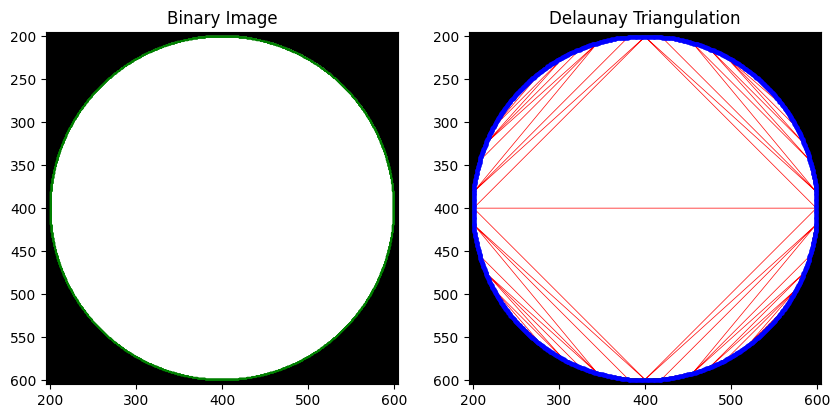

In [15]:
# Example usage
binary_image = np.zeros((800, 800), dtype=np.uint8)
rr, cc = disk((400, 400), 200)
binary_image[rr, cc] = 1
np.save("data/circle.npy", binary_image)
binary_circle = binary_image.copy()

# Perform Delaunay triangulation
tri = delaunay_triangulation(binary_image)
hull_points = convex_hull_points(binary_image)
boundary_points = get_boundary_points(binary_image)

# Plot the binary image and the Delaunay triangulation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.title('Binary Image')
plt.xlim(195, 605)
plt.ylim(605, 195)

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.5)
plt.plot(boundary_points[:, 1], boundary_points[:, 0], 'bo', markersize=2)
plt.title('Delaunay Triangulation')
plt.xlim(195, 605)
plt.ylim(605, 195)


plt.show()

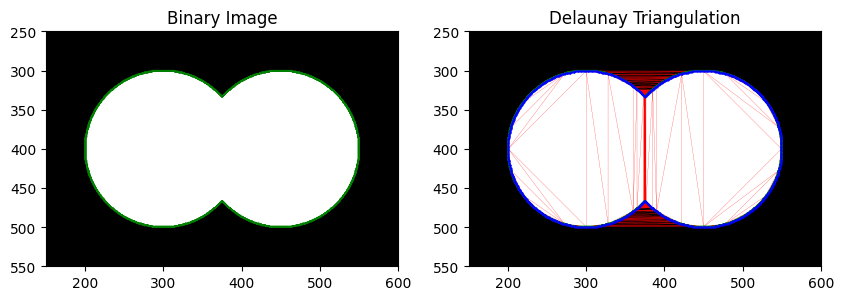

In [16]:
# Try with two cells conjoined together
binary_image = np.zeros((800, 800), dtype=np.uint8)
rr, cc = disk((400, 300), 100)
rr2, cc2 = disk((400, 450), 100)

binary_image[rr, cc] = 1
binary_image[rr2, cc2] = 1
np.save("data/overlapping_circles.npy", binary_image)


# Perform Delaunay triangulation
tri = delaunay_triangulation(binary_image)
#hull_points = convex_hull_points(binary_image)
boundary_points = get_boundary_points(binary_image)

# Plot the binary image and the Delaunay triangulation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.title('Binary Image')
plt.xlim(150, 600); plt.ylim(550, 250)

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.15)
plt.plot(boundary_points[:, 1], boundary_points[:, 0], 'bo', markersize=0.5)
plt.title('Delaunay Triangulation')
plt.xlim(150, 600); plt.ylim(550, 250)



plt.show()

/tmp/ipykernel_26927/412382972.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


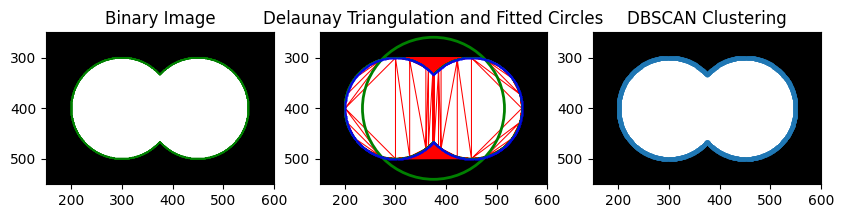

In [104]:
# Function to fit a circle to a set of points
def fit_circle(points):
    """
    Fit a circle to a set of points using the least squares method.
    
    Parameters:
    - points: 2D numpy array of shape (n_points, 2) representing the coordinates of the points.
    
    Returns:
    - center: Coordinates of the center of the fitted circle.
    - radius: Radius of the fitted circle.
    """
    x = points[:, 0]
    y = points[:, 1]
    A = np.column_stack([x, y, np.ones_like(x)])
    b = x**2 + y**2
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    center = c[:2] / 2
    radius = np.sqrt(c[2] + center[0]**2 + center[1]**2)
    return center, radius

# Example usage
binary_image = np.zeros((800, 800), dtype=np.uint8)
rr, cc = disk((400, 300), 100)
rr2, cc2 = disk((400, 450), 100)

binary_image[rr, cc] = 1
binary_image[rr2, cc2] = 1

# Perform Delaunay triangulation
tri = delaunay_triangulation(binary_image)
boundary_points = get_boundary_points(binary_image)

# Cluster the points using DBSCAN
#points = np.column_stack(np.nonzero(binary_image))
points = boundary_points
clustering = DBSCAN(eps=20, min_samples=10).fit(points)
labels = clustering.labels_

# Fit circles to the clusters
unique_labels = np.unique(labels)
circles = []
for label in unique_labels:
    if label == -1:
        continue  # Skip noise points
    cluster_points = points[labels == label]
    center, radius = fit_circle(cluster_points)
    circles.append((center, radius))

# Plot the binary image, Delaunay triangulation, and fitted circles
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.title('Binary Image')
plt.xlim(150, 600); plt.ylim(550, 250)

plt.subplot(1, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
plt.plot(boundary_points[:, 1], boundary_points[:, 0], 'bo', markersize=0.25)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.75)
for center, radius in circles:
    circle = plt.Circle((center[1], center[0]), radius, color='green', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title('Delaunay Triangulation and Fitted Circles')
plt.xlim(150, 600); plt.ylim(550, 250)


# 3
"""
plt.subplot(1, 3, 3)
placeholder = np.zeros(binary_image.shape)
plt.imshow(placeholder, cmap='gray')
#plt.imshow(binary_image, cmap='gray')
#plt.plot(tri.points[:, 1], tri.points[:, 0], 'ro', markersize=0.25)
plt.triplot(tri.points[:, 1], tri.points[:, 0], tri.simplices, color='red', linewidth=0.15)
plt.title('Delaunay Triangulation points')
plt.xlim(150, 600); plt.ylim(550, 250)
"""


# Plot the DBSCAN clustering result
plt.subplot(1, 3, 3)
plt.imshow(binary_image, cmap='gray')
plt.contour(binary_image, colors='green', linewidths=1)
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))
for label in unique_labels:
    if label == -1:
        color = 'k'  # Black for noise
    else:
        color = colors(label)
    cluster_points = points[labels == label]
    plt.plot(cluster_points[:, 1], cluster_points[:, 0], 'o', markerfacecolor=color, markersize=2)
plt.title('DBSCAN Clustering')
plt.xlim(150, 600); plt.ylim(550, 250)

plt.show()


plt.show()

median distance: 4.123105625617661
average distance: 22.169972459554597


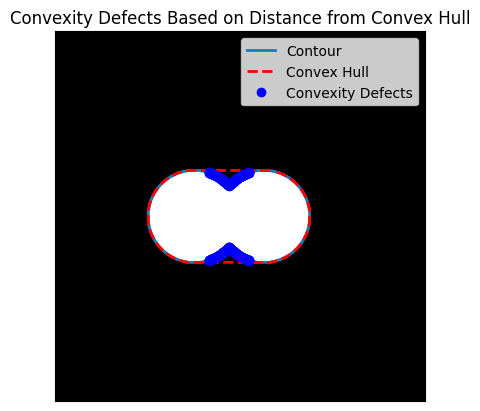

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color, measure
from scipy.spatial import ConvexHull, distance

# Threshold the image
binary = binary_image

# Find contours using skimage
contours = measure.find_contours(binary, level=0.5)

# Assuming the largest contour corresponds to the conjoined circles
main_contour = max(contours, key=len)

# Convert the contour to (x, y) coordinates
main_contour = np.array(main_contour)

# Calculate the convex hull of the contour
hull = ConvexHull(main_contour)

# Identify convexity defects (points not on the convex hull)
hull_points = main_contour[hull.vertices]

# Function to calculate the minimum distance from a point to a set of points
def point_to_hull_distance(point, hull_points):
    return np.min(distance.cdist([point], hull_points))

# Calculate distances from each contour point to the convex hull
distances = np.array([point_to_hull_distance(point, hull_points) for point in main_contour])

# Define a threshold for "defects" based on distance from the convex hull
median_distance = np.median(distances)
average_distance = np.mean(distances)
print("median distance:", median_distance)
print("average distance:", average_distance)
distance_threshold = 2 * average_distance #  15  # Adjust based on your specific image (higher values for larger distances)
defect_points = main_contour[distances > distance_threshold]

# Plot the original image and contours
fig, ax = plt.subplots()
ax.imshow(binary, cmap=plt.cm.gray)

# Plot the main contour
ax.plot(main_contour[:, 1], main_contour[:, 0], linewidth=2, label='Contour')

# Plot the convex hull
ax.plot(hull_points[:, 1], hull_points[:, 0], 'r--', lw=2, label='Convex Hull')

# Plot the defect points (concave points where the circles might be joined)
ax.plot(defect_points[:, 1], defect_points[:, 0], 'bo', label='Convexity Defects')

# Add legend and titles
ax.legend()
ax.set_title('Convexity Defects Based on Distance from Convex Hull')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()